In [169]:
import urllib
import re
import lxml.html
import unicodedata
import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class Song(object):
    def __init__(self, artist, title):
        self.artist = self.__format_str(artist)
        self.title = self.__format_str(title)
        self.url = None
        self.lyric = None

    def __format_str(self, s):
        # remove paranthesis and contents
        s = s.strip()
        try:
            # strip accent
            s = ''.join(c for c in unicodedata.normalize('NFD', s)
                         if unicodedata.category(c) != 'Mn')
        except:
            pass
        s = s.title()
        return s

    def __quote(self, s):
         return urllib.parse.quote(s.replace(' ', '_'))

    def __make_url(self):
        artist = self.__quote(self.artist)
        title = self.__quote(self.title)
        artist_title = '%s:%s' %(artist, title)
        url = 'http://lyrics.wikia.com/' + artist_title
        self.url = url
        print(url)

    def update(self, artist=None, title=None):
        if artist:
            self.artist = self.__format_str(artist)
        if title:
            self.title = self.__format_str(title)

    def lyricwikia(self):
        self.__make_url()
        try:
            doc = lxml.html.parse(self.url)
            lyric_list = doc.getroot().cssselect('.lyricbox')            
            if len(lyric_list) == 0:
                self.url = 'http://lyrics.wikia.com' + ''.join(doc.xpath('//div[@id="mw-content-text"]//a/@href'))
                doc = lxml.html.parse(self.url)
                lyric_list = doc.getroot().cssselect('.lyricbox')          
            lyricbox = lyric_list[0]
        except IOError:
            self.lyric = ''
            return
        lyrics = []       
        for node in lyricbox:
            if node.tag == 'br':
                lyrics.append('\n')
            if node.tail is not None:
                lyrics.append(node.tail)
        self.lyric =  "".join(lyrics).strip()    
        return self.lyric
    

class Song_By_Artist(object):
    def __init__(self, artist):
        self.artist = self.__format_str(artist)
        self.lyric = []
        self.__make_url()

    def __format_str(self, s):
        # remove paranthesis and contents
        s = s.strip()
        try:
            s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
        except:
            pass
        s = s.title()
        return s
    
    def __quote(self, s):
         return urllib.parse.quote(s.replace(' ', '_'))
    
    def __make_url(self):
        artist = self.__quote(self.artist)
        url = 'http://lyrics.wikia.com/wiki/' + artist
        self.url = url
    
    def lyricwikia(self):
        url = self.url
        doc = lxml.html.parse(url)
        for i in doc.xpath('//ol[last()-2]//li//b/a//@href'):
            if self.artist not in i:
                continue
            url = 'http://lyrics.wikia.com' + i
            title = self.__format_str(i[7 + len(self.artist) :])
            print(url)   
            try:
                doc = lxml.html.parse(url)
                lyric_list = doc.getroot().cssselect('.lyricbox')                     
                lyricbox = lyric_list[0]
            except IOError:
                self.lyric = ''
            lyrics = []       
            for node in lyricbox:
                if node.tag == 'br':
                    lyrics.append('\n')
                if node.tail is not None:
                    lyrics.append(node.tail)
            text_file = open("datasets\%s_Lyric\%s.txt" %(self.artist, title), "w", encoding="utf-8", errors = 'ignore')
            text_file.write("%s" % (''.join(lyrics)))
            text_file.close()
            
            
def clean(dir):
    #dir = os.path.join('datasets', 'Lyric')
    lyric_by_song = {}
    lyric_raw = []
    i = 1
    for filename in os.listdir(dir):
        if i % 100 == 0:
            print("%i lyrics tokenized and lemmatized" %i)
        path = os.path.join(dir, filename)
        file_content = open(path, "r", encoding="utf-8",).read()
    
        tokenizer = RegexpTokenizer(r'\w+')
        lemmatizer = WordNetLemmatizer()    
        tokens = tokenizer.tokenize(file_content)
        tokens = [t.lower() for t in tokens]
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    
    
        #filter out stop words
        stop_words_e = set(stopwords.words('english'))
        stop_words_s = set(stopwords.words('spanish'))   
        words = [w for w in lemmas if ((not w in stop_words_e) and (not w in stop_words_s))]
    
        lyric_raw.extend(words)
        lyric_by_song[filename] = words
        i = i + 1
        
    print("Tokenization and Lemmatization Finished!!!!")
    return lyric_by_song, lyric_raw

def plot(lyric_raw, top_common):
    fdist = nltk.FreqDist(lyric_raw)
    total = fdist.N()
    for word in fdist:
        fdist[word] /= (float(total) / 100)
    
    common = fdist.most_common(top_common)
    words, freqs = zip(*common)

    plt.rcdefaults()
    fig, ax = plt.subplots()

    y_pos = np.arange(len(words))
    error = np.random.rand(len(words))

    ax.barh(y_pos, freqs, color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency %')
    ax.set_title('%i most frequent words for Drake lyrics' %top_common)

    plt.show()

In [2]:
datapath_song = 'datasets\Song\songs.csv'
songs = pd.read_csv(datapath_song)

In [4]:
#Sort the songs by stream number in descending order
songs.sort_values(by='Streams', ascending=False, inplace=True)

#Drop duplicated songs
songs.drop_duplicates('Track Name', inplace=True)

#Drop null
songs.dropna(axis=0, how='any', inplace=True)

#Drop Non-English Title
#songs = songs[songs['Track Name'].str.isalnum()]

#Reset index
songs.index = range(len(songs))

#Inspect data
songs.info(verbose=True)

songs.to_csv('datasets\Song\songs_clean.csv', sep=',', encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18597 entries, 0 to 18596
Data columns (total 7 columns):
Position      18597 non-null int64
Track Name    18597 non-null object
Artist        18597 non-null object
Streams       18597 non-null int64
URL           18597 non-null object
Date          18597 non-null object
Region        18597 non-null object
dtypes: int64(2), object(5)
memory usage: 1017.1+ KB


In [7]:
track_list = np.array(songs['Track Name'])
artist_list = np.array(songs['Artist'])
rankings = np.array(list(songs.index))

for track, artist, ranking in zip(track_list, artist_list, rankings):
    print(track, artist, ranking)
    song = Song(artist=artist, title=track)
    lyr = song.lyricwikia()
    text_file = open("datasets\Lyric\%d.txt" %ranking, "w", encoding="utf-8", errors = 'ignore')
    text_file.write("%s" % lyr)
    text_file.close()
fp.close()


In [168]:
dir = os.path.join('datasets', 'Lyric')
lyric_by_song, lyric_raw = clean(dir)

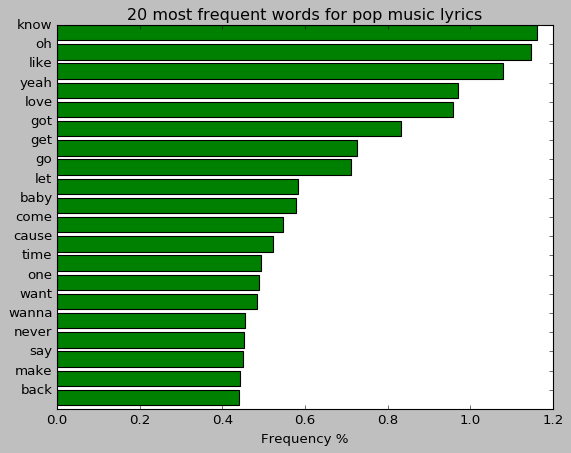

In [167]:
plot(lyric_raw, 20)

In [162]:
drake = Song_By_Artist('Drake')
drake.lyricwikia()

In [159]:
dir = os.path.join('datasets', 'Drake_Lyric')
lyric_by_song, lyric_raw = clean(dir)

Tokenization and Lemmatization Finished!!!!


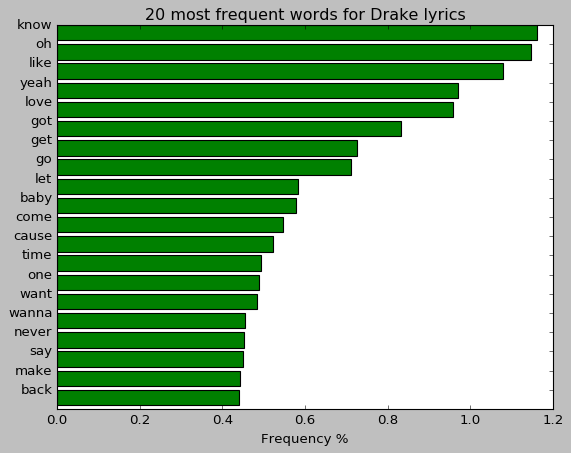

In [170]:
plot(lyric_raw, 20)